# Comparing poisson and negative binomial regression

This notbook replicates the nice examples by Sachin Date posted on towardsdatascience on how to model bike traffic across bridges in NYC. He considers both Poisson and Negative Binomial regressions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

import statsmodels.api as sm

/home/seb/py36/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 1) Poisson model

https://towardsdatascience.com/an-illustrated-guide-to-the-poisson-regression-model-50cccba15958

In [2]:
df = pd.read_csv('./nyc_bb_bicyclist_counts.csv', header=0, infer_datetime_format=True, parse_dates=[0], index_col=[0])

In [3]:
ds = df.index.to_series()
df['MONTH'] = ds.dt.month
df['DAY_OF_WEEK'] = ds.dt.dayofweek
df['DAY'] = ds.dt.day
df

,HIGH_T,LOW_T,PRECIP,BB_COUNT,MONTH,DAY_OF_WEEK,DAY
Date,,,,,,,
2017-04-01,46.0,37.0,0.00,606,4,5,1
2017-04-02,62.1,41.0,0.00,2021,4,6,2
2017-04-03,63.0,50.0,0.03,2470,4,0,3
2017-04-04,51.1,46.0,1.18,723,4,1,4
2017-04-05,63.0,46.0,0.00,2807,4,2,5
...,...,...,...,...,...,...,...
2017-10-27,62.1,48.0,0.00,3150,10,4,27
2017-10-28,68.0,55.9,0.00,2245,10,5,28
2017-10-29,64.9,61.0,3.03,183,10,6,29


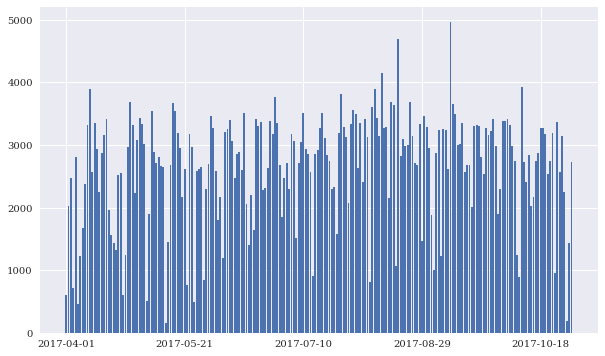

In [4]:
f, ax = plt.subplots(1,1, figsize=(10, 6))
ax.bar(df.index, df.BB_COUNT)
ax.set_xticks(df.index[[0, 50, 100, 150, 200]])
plt.show()

creating training at test sets

Sachin does a random split into train and test to predict bike traffic. This seems wrong. We will do a standard temporal split to avoid data leakage.

In [5]:
df_train = df.iloc[0:4*df.shape[0]//5,:]
df_test = df.iloc[4*df.shape[0]//5:df.shape[0]+1,:]
print('Train set length='+str(len(df_train)))
print('Test set length='+str(len(df_test)))

Train set length=171
Test set length=43


In [6]:
y_train = df_train.BB_COUNT.values
y_test = df_test.BB_COUNT.values
X_train = np.concatenate([np.ones(df_train.shape[0]).reshape(-1,1),
                          df_train.DAY.values.reshape(-1,1),
                          df_train.DAY_OF_WEEK.values.reshape(-1,1),
                          df_train.MONTH.values.reshape(-1,1),
                          df_train.HIGH_T.values.reshape(-1,1),
                          df_train.LOW_T.values.reshape(-1,1),
                          df_train.PRECIP.values.reshape(-1,1)],
                         axis=1)
X_test = np.concatenate([np.ones(df_test.shape[0]).reshape(-1,1),
                          df_test.DAY.values.reshape(-1,1),
                          df_test.DAY_OF_WEEK.values.reshape(-1,1),
                          df_test.MONTH.values.reshape(-1,1),
                          df_test.HIGH_T.values.reshape(-1,1),
                          df_test.LOW_T.values.reshape(-1,1),
                          df_test.PRECIP.values.reshape(-1,1)],
                         axis=1)

In [7]:
m = sm.GLM(endog = y_train,
           exog = X_train,
           family = sm.families.Poisson()).fit()

In [8]:
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  171
Model:                            GLM   Df Residuals:                      164
Model Family:                 Poisson   Df Model:                            6
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12394.
Date:                Thu, 16 Apr 2020   Deviance:                       23138.
Time:                        22:54:17   Pearson chi2:                 2.30e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.9437      0.012    572.461      0.000       6.920       6.967
x1             0.0014      0.000      7.856      0.000       0.001       0.002
x2            -0.0186      0.001    -25.309      0.000      -0.020      -0.017
x3             0.0304      0.001     27.397      0.000       0.028       0.033
x4             0.0247      0.000     73.215      0.000       0.024       0.025
x5            -0.0160      0.000    -41.159      0.000      -0.017      -0.015
x6            -0.7305      0.007   -103.481      0.000      -0.744      -0.717
==============================================================================
"""

In [9]:
y_pred_poisson = m.predict(X_test)

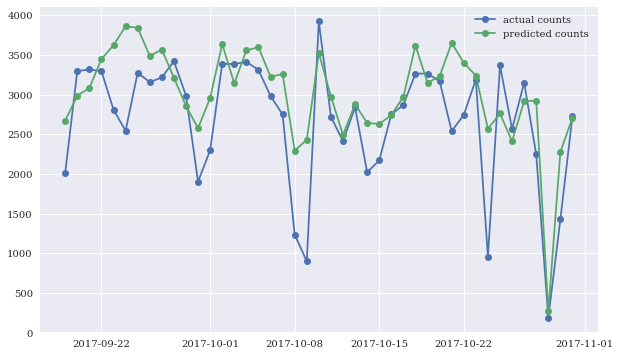

In [10]:
f, ax = plt.subplots(1,1, figsize=(10,6))

ax.plot(df_test.index, y_test, 'o-', label='actual counts')
ax.plot(df_test.index, y_pred_poisson, 'o-', label='predicted counts')

ax.legend()

plt.show()

# 2) Negative Binomial model

https://towardsdatascience.com/negative-binomial-regression-f99031bb25b4

We use the same data, train and test sets are defined as above

## 2.1) Run poisson regression to find the $\lambda_i$

In [11]:
m = sm.GLM(endog = y_train,
           exog = X_train,
           family = sm.families.Poisson()).fit()

recall that $\lambda_i = \mathrm{e}^{\mathbf{\theta}'\mathbf{x}_i}$. In statsmodels, these are stored in the `model_name.mu`. Uncomment the following line to verify.

In [12]:
# np.exp(X_train @ m.params.reshape(-1,1)) - m.mu.reshape(-1,1)

## 2.2) Run the auxiliary OLS regression without intercept to find $\alpha$ and check if it is significant

In [13]:
aux_ols_dep = ((y_train - m.mu) ** 2 - y_train) / m.mu

In [14]:
mols = sm.OLS(aux_ols_dep, m.mu.reshape(-1,1)).fit()

In [15]:
mols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.158
Model:                            OLS   Adj. R-squared (uncentered):              0.153
Method:                 Least Squares   F-statistic:                              31.90
Date:                Thu, 16 Apr 2020   Prob (F-statistic):                    6.69e-08
Time:                        22:54:17   Log-Likelihood:                         -1185.6
No. Observations:                 171   AIC:                                      2373.
Df Residuals:                     170   BIC:                                      2376.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0389      0.007      5.648      0.000       0.025       0.052
==============================================================================
Omnibus:                      134.910   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1100.769
Skew:                           3.064   Prob(JB):                    9.36e-240
Kurtosis:                      13.814   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We see that alpha is significant and equals

In [16]:
alpha = mols.params[0]
alpha

0.03890351605413943

## 2.3) Fit the negative binomial with the alpha we found

In [17]:
m = sm.GLM(endog = y_train,
           exog = X_train,
           family = sm.families.NegativeBinomial(link=None, alpha=alpha)).fit()

In [18]:
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  171
Model:                            GLM   Df Residuals:                      164
Model Family:        NegativeBinomial   Df Model:                            6
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1384.9
Date:                Thu, 16 Apr 2020   Deviance:                       337.53
Time:                        22:54:17   Pearson chi2:                     299.
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.6466      0.115     57.933      0.000       6.422       6.871
x1             0.0003      0.002      0.147      0.883      -0.003       0.004
x2            -0.0144      0.008     -1.912      0.056      -0.029       0.000
x3             0.0234      0.012      1.973      0.048       0.000       0.047
x4             0.0310      0.003      9.145      0.000       0.024       0.038
x5            -0.0182      0.004     -4.491      0.000      -0.026      -0.010
x6            -0.6064      0.043    -14.059      0.000      -0.691      -0.522
==============================================================================
"""

## 2.4) Predict and compare

In [19]:
y_pred_nb = m.predict(X_test)

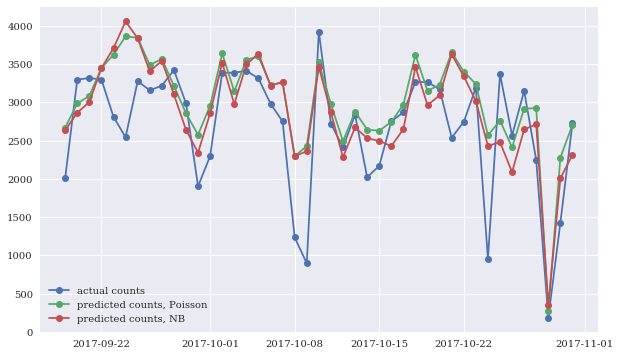

In [20]:
f, ax = plt.subplots(1,1, figsize=(10,6))

ax.plot(df_test.index, y_test, 'o-', label='actual counts')
ax.plot(df_test.index, y_pred_poisson, 'o-', label='predicted counts, Poisson')
ax.plot(df_test.index, y_pred_nb, 'o-', label='predicted counts, NB')

ax.legend()

plt.show()